<h1>Multilabel classification for clothes attributes recognition with DeepFashion Dataset and Fastai</h1>
<p>This Notebook presents a solution for a fine-grained multilabel classification problem. The solution implemented using PyTorch and FastAI libraries. The model trained on a Windows machine with GTX 1080Ti Turbo GPU.</p>

In [1]:
from fastai.vision.all import *
import gc 

<h2>Data</h2>
<p>The model is trained on a <a href="http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html">DeepFashion</a> Dataset, a large-scale clothes database for Clothing Category and Attribute Prediction collected by Multimedia Lab at The Chinese University of Hong Kong. The current benchmark was published in 2016, it evaluates the performance of the FashionNet Model in predicting 46 categories and 1000 attributes of clothes. For original paper please refer to <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_DeepFashion_Powering_Robust_CVPR_2016_paper.pdf">DeepFashion: Powering Robust Clothes Recognition and Retrieval with Rich Annotations, CVPR 2016</a>.</p>

<p>The DeepFashion Database contains several datasets. For this project, the Category and Attribute Prediction Benchmark was used. This dataset contains 289,222 diverse clothes images labeled with 1000 different attributes. From which I used 98 attributes that correspond to style, fabric, season, and type of the pattern.</p>

In [2]:
PATH = "fasion-adviser/deepfashion-dataset/"
TRAIN_PATH = "fasion-adviser/deepfashion-dataset/cloth_categories/multilabel-train.csv"
TEST_PATH = "fasion-adviser/deepfashion-dataset/cloth_categories/multilabel-test.csv"
CLASSES_PATH = "cloth_categories/attribute-classes.txt"

<p>Training data are stored in multilabel-train.csv. Let's load the file and look at what is inside.</p>

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.head()

,image_name,labels,is_valid
0,img\Sheer_Pleated-Front_Blouse\img_00000002.jpg,"pleated,sheer",0.0
1,img\Sheer_Pleated-Front_Blouse\img_00000003.jpg,"chic,pleated",1.0
2,img\Sheer_Pleated-Front_Blouse\img_00000006.jpg,pleated,1.0
3,img\Sheer_Pleated-Front_Blouse\img_00000009.jpg,"sheer,sophisticated",0.0
4,img\Sheer_Pleated-Front_Blouse\img_00000010.jpg,"relaxed,sheer,woven",0.0


<p>The dataset contains the location of the images, labels stored as a string object, and whether the image belongs to a validation set.</p>
<p>To load the images, we will use a <i>DataBlock</i>, that expects as input the full path to the image as an independent variable and the list of strings as the labels. For that, we will create two helper functions to parse the input format. We will also create a splitter function that will create train and validation sets based on the <i>is_valid</i> column.</p>

In [4]:
def get_x(r): return PATH+r['image_name']
def get_y(r): return r['labels'].split(',')

In [5]:
def splitter(df):
    train = df.index[df['is_valid']==0].tolist()
    valid = df.index[df['is_valid']==1].tolist()
    return train,valid

<p>We specify the type of the independet variable as an ImageBlock, and the label as MultiCategoryBlock. MultiCategoryBlock expects labels to be stored as a list of strings. get_y method will take care of it.</p>
<p><i>RandomResizedCrop</i> randomly crops a part of the image. Each epoch it crops a different part of the image.</p>
<p><i>aug_transforms</i> - creates a list of audumentations such as horisontal flip, rotation, zoom, warp, and lighting transforms.</p>

In [6]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(224, min_scale=0.8),
                   batch_tfms=aug_transforms())

dls = dblock.dataloaders(train_df, num_workers=0)

<p>Let's look at some images in our dataset. As we can see the original dataset incorporates some noise in labels. That will affect the quality of the model.</p>

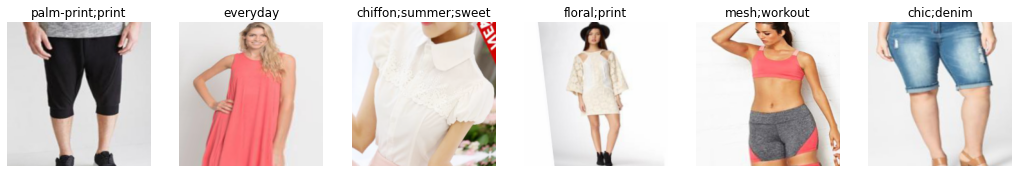

In [7]:
dls.show_batch(nrows=1, ncols=6)

<h2>The choice of the evaluation metric</h2>
<p>Now when the data are loaded let's take a look at the target variable:</p>

In [8]:
dsets = dblock.datasets(train_df)

In [9]:
dsets.train[0]

(PILImage mode=RGB size=205x300,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

<p>The list of labels that we passed to the DataBlock was transformed to the sparse One-Hot encoded vector. The sparsity will affect our choice of the evaluation metric. The default choice for the evaluation metric in fastai is <i>accuracy_multi</i>. However it will not work well with the sparse labels, let's see why:</p>

In [10]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

<p>If we create a tensor of zeroes and send it to accuracy_multi together with the target values we will already achieve 98% accuracy. This means that if our model would not predict any label, it would already be 98% accurate.</p>

In [11]:
number_of_classes = len(dsets.train[0][1])
fake_prediction = torch.tensor([[0.0] * number_of_classes])
fake_prediction

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [12]:
target = dsets.train[0][1].reshape(1,-1)
accuracy_multi(fake_prediction, target,  thresh=0.5, sigmoid=True)

TensorMultiCategory(0.9796)

<p>Therefore we need another evaluation metric, that will reflect the realistic learning progress and performance of our model. For example <b>FBeta</b> score.</p>
<p><b>FBeta</b> is a generalisation of <b>F-score</b>. While <b>F-score</b> is defined as the harmonic mean of precision and recall and gives each the same weight, <b>FBeta</b> adds a configuration parameter called beta. The beta parameter determines the weight of recall in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors recall (beta -> 0 considers only precision, beta -> +inf only recall).</p>
<p>Let's look how it handles our "0-prediction" problem.</p>

In [13]:
from sklearn.metrics import fbeta_score
fbeta_score(fake_prediction, target, beta=2, average='samples')

0.0

<p>In case of no prediction it will give us a 0 FBeta score. We can also test few other extreme cases:</p>

In [14]:
# create a random prediction
import random
random_list = [0.0]*int(number_of_classes/2) + [1.0]*int(number_of_classes/2)
random.shuffle(random_list)
fake_prediction = torch.tensor([random_list])
fake_prediction

tensor([[1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
         0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
         1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
         1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
         0., 1., 0., 1., 1., 1., 1., 1.]])

In [15]:
fbeta_score(fake_prediction, target, beta=2, average='samples')

0.0

In [16]:
# create a perfect prediction where prediction=target
fbeta_score(fake_target, target, beta=2, average='samples')

1.0

<h2>The choice of the loss function</h2>
<p>Going back to the example of traing labels. It is represented as a One-Hot encoded vector. This type of encoding is also known as a <b>hard encoding</b>.</p> 

In [17]:
dsets.train[0]

(PILImage mode=RGB size=205x300,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

<p>When we use hard encoded labels, the predicted probabilities for correct labels will be extremely large and for the incorrect classes extremely low. The model will classify every training example correctly with the confidence of almost 1. This might lead to multiple problems, the first problem is overfitting. The other two problems are related to the nature of labels in our dataset.</p>

In [18]:
dls.vocab

['abstract-print', 'animal', 'baroque', 'basic', 'beach', 'bird-print', 'boho', 'botanical-print', 'camouflage', 'cargo', 'chic', 'chiffon', 'circle', 'civil', 'colorblock', 'cotton', 'cozy', 'crochet', 'cute', 'denim', 'dotted', 'elegant', 'everyday', 'fancy', 'faux-fur', 'faux-leather', 'faux-suede', 'feather', 'floral', 'fur', 'glitter', 'graphic', 'grid-print', 'grunge', 'knotted', 'leaf-print', 'leather', 'leopard-print', 'linen', 'linen-blend', 'logo', 'luxe', 'marble-print', 'medallion-print', 'mesh', 'metallic', 'mixed-print', 'multi-stripe', 'neon', 'neoprene', 'nets', 'netted', 'nylon', 'oil', 'ombre', 'organza', 'ornate-print', 'paisley-print', 'palm-print', 'party', 'patched', 'pattern', 'pleated', 'print', 'relaxed', 'retro', 'safari', 'sateen', 'satin', 'sheer', 'smart', 'soft', 'solid', 'sophisticated', 'sparkling', 'sporty', 'springs', 'square', 'star', 'strap', 'stretch', 'striped', 'suede', 'summer', 'sweet', 'textured', 'thermal', 'tie-dye', 'training', 'triangle', '

<p>The clothes attribute labels are semantically very cloth. For example: 'botanical-print' and 'floral', or 'faux-leather' and 'leather' are very hard to distinguish even for a human. When we train a network with semantically similar labels encoded as One-Hot, the difference between correct and incorrect classes is extremely high, even though they might be very cloth semantically. The confidence with which model will predict the labels is not limited and might vary across classes, which makes the separation of a correct class more challenging.</p>

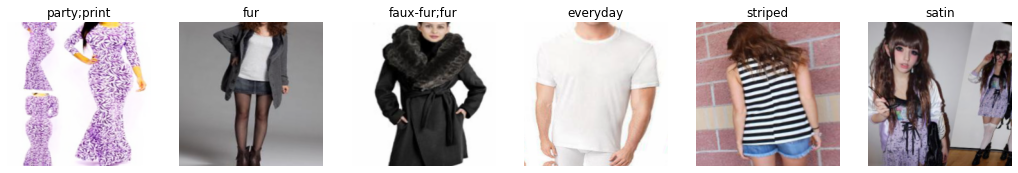

In [19]:
dls.show_batch(nrows=1, ncols=6)

<p> Finally, as we have seen in the <a href="https://towardsdatascience.com/clothes-classification-with-the-deepfashion-dataset-and-fast-ai-1e174cbf0cdc">clothes type classification problem</a>, the DeepFashion dataset suffers from noisy labels. The data are manually annotated by multiple participants who might have had different labeling criteria, which leads to the data mislabeling. As the result, the model trained with hard encoded labels will learn incorrect features with a high level of confidence. Therefore we need to challenge the labels in our dataset and ask ourselves whether the true labels are really true? One possible solution is to assign the probabilities to our labels. We can do it by lowering the loss target values from 1 to, say, 0.9. That approach is called Labels Smoothing and was discussed in great detail in the paper <a href="https://arxiv.org/pdf/1906.02629.pdf">When Does Label Smoothing Help?</a>.</p> <p>Labels smoothing prevents the network from becoming over-confident and it will less likely overfit. Moreover, it makes the differences between the correct and incorrect classes constant by introducing a smoothing parameter α. As a result, each incorrect class label will be equidistant from the correct ones which make it easier to separate semantically similar classes. We will implement the label smoothing inside the loss function and use it to train our model.</p>

<p>In fastai the default choice of the loss function for a multi-label classification problem is a BCEWithLogitsLossFlat, which is a Binary Cross Entropy with Logits (in fact a sigmoid function, which is an inverse of the logit function and maps arbitrary real values of Cross-Entropy back to the [0, 1] range which is what we usually want for the targets encoded between 0 and 1).</p>
<p>We will wrap BCEWithLogitsLossFlat in a LabelSmoothingBCEWithLogitsLossFlat class and apply label smoothing before calling the BCEWithLogitsLossFlat</p>

In [20]:
class LabelSmoothingBCEWithLogitsLossFlat(BCEWithLogitsLossFlat):
    def __init__(self, eps:float=0.1, **kwargs):
        self.eps = eps
        super().__init__(thresh=0.2, **kwargs)
    
    def __call__(self, inp, targ, **kwargs):
        # https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/166833#929222
        targ_smooth = targ.float() * (1. - self.eps) + 0.5 * self.eps
        return super().__call__(inp, targ_smooth, **kwargs)
    
    def __repr__(self):
        return "FlattenedLoss of LabelSmoothingBCEWithLogits()"

<p>Let's compare the loss values while training the network with  BCEWithLogitsLossFlat and LabelSmoothingBCEWithLogitsLossFlat:</p>

In [21]:
metrics=[FBetaMulti(2.0, 0.2, average='samples'), partial(accuracy_multi, thresh=0.2)]

<p>We will use a <a href="https://en.wikipedia.org/wiki/Residual_neural_network">Resnet34</a> architecture pretrained on the ImageNet dataset.</p>

In [22]:
wd      = 5e-7 #weight decay parameter
opt_func = partial(ranger, wd=wd)

<p>Without Labels Smoothing:</p>

In [23]:
learn = cnn_learner(dls, resnet34, loss_func=BCEWithLogitsLossFlat(thresh=0.2),
            metrics=metrics, opt_func=opt_func).to_fp16()

<p>When we call learn.fine_tune(), we freeze the entire network, and train for an epoch only the randomly initialized activations of the newly created layer. Then we unfreeze the network and train all layers together for the number of epochs we specified (in our case two). That is why we see the result for three epochs and not two when calling learn.fine_tune()</p>

In [24]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,fbeta_score,accuracy_multi,time
0,0.058381,0.053776,0.317861,0.983668,10:46


epoch,train_loss,valid_loss,fbeta_score,accuracy_multi,time
0,0.052066,0.048454,0.402915,0.984397,13:45
1,0.048215,0.046943,0.426415,0.984490,12:33


<p>We can see that the values of loss are very small. Due to the 0|1 targets, the model is overconfident about the labels it assigns.</p>
<p>Now let's train the network with the label smoothing:</p>

In [25]:
learn = cnn_learner(dls, resnet34, loss_func=LabelSmoothingBCEWithLogitsLossFlat(),
            metrics=metrics, opt_func=opt_func).to_fp16()

In [26]:
learn.fine_tune(2)
learn.save('atr-recognition-stage-1-resnet34')

epoch,train_loss,valid_loss,fbeta_score,accuracy_multi,time
0,0.233737,0.228623,0.338600,0.981511,10:37


epoch,train_loss,valid_loss,fbeta_score,accuracy_multi,time
0,0.227728,0.225587,0.409044,0.983584,11:55
1,0.226339,0.224716,0.429240,0.983635,11:59


Path('models/atr-recognition-stage-1-resnet34.pth')

<p>The loss increased when we run our model with the label smoothing, which might be counterintuitive at first. The reason is that the label smoothing decreases the certainty in the targets. The higher loss is in fact a desirable outcome in this case.</p>
<p>We can also observe that the model has 98% accuracy just after the one epoch of training, that is the problem we discussed earlier while choosing an evaluation metric.</p>

<h2>Discriminative Learning Rates</h2>
<p>Let's go through the data in our DataLoader and gradually increase the learning rate with each mini-batch, to observe how the value of loss changes with the change of learning rate. Our goal is to find the most efficient learning rate that will allow the network to converge faster.</p>

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=1.3182567499825382e-06)

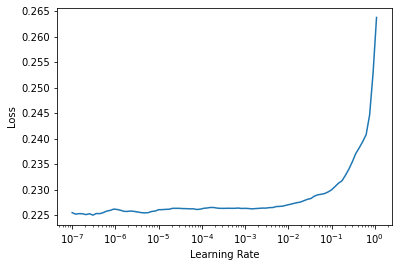

In [27]:
learn.unfreeze()
learn.lr_find()

<p>Since our model has already been trained for three epochs, the weights of the network are not random anymore and we do not observe any sharp drops of loss. For further training, we will take a range of weights from the point of decrease till the point where the loss starts growing again and check if we can improve our model.
The layers transferred from the pre-trained model are already good at recognizing fundamental visual concepts and do not require much training. While deeper layers that are responsible for recognizing complex shapes specific to our project, still will benefit from higher learning rates. Therefore we need to use smaller learning rates for the first layers and bigger learning rates for the last layers, to allow them to fine-tune more quickly than earlier layers.</p>

In [28]:
learn.fit_one_cycle(8, lr_max=slice(5e-7, 1e-4))

epoch,train_loss,valid_loss,fbeta_score,accuracy_multi,time
0,0.226294,0.224668,0.432401,0.983527,12:45
1,0.226127,0.224570,0.434137,0.983594,13:00
2,0.226252,0.224492,0.438158,0.983602,12:14
3,0.225729,0.224438,0.440502,0.983568,11:52
4,0.225114,0.224385,0.441365,0.983659,11:56
5,0.225403,0.224334,0.442502,0.983679,12:15
6,0.225099,0.224321,0.442130,0.983759,12:58
7,0.225262,0.224338,0.442530,0.983778,12:37


<p>Plotting the training and validation loss can help us to evaluate whether we need to continue training. As we can see the validation loss doesn't improve that much anymore, even though the training loss is still improving. By continuing training, we will increase the gap between the training and validation loss which will mean that we overfitted our model. Therefore we better stop the training now.</p>

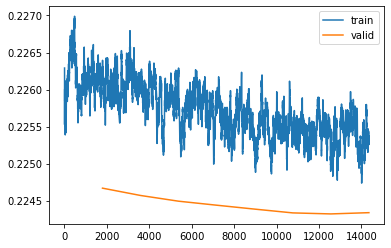

In [29]:
learn.recorder.plot_loss()

In [30]:
learn.save('atr-recognition-stage-2-resnet34')

modelname = learn.model
modelname.cpu()
torch.save(modelname, 'atr-recognition-stage-2-resnet34.pkl')

with open(PATH+CLASSES_PATH, 'w') as f:
    for item in dls.vocab:
        f.write("%s\n" % item)

<h2>Evaluation</h2>
<p>It is a time to evaluate the performance of the trained model. The next plot shows the validation FBeta score after each epoch of training.</p>

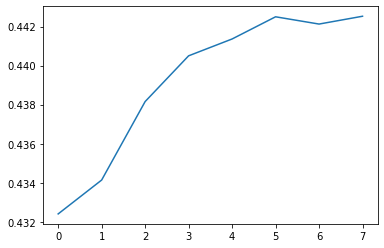

In [31]:
plt.plot(L(learn.recorder.values).itemgot(2))

<h3>Evaluation on the Training Dataset</h3>
<p>First, we will look at the predictions on the training dataset in order to estimate if our model learned a reasonable pattern.</p>

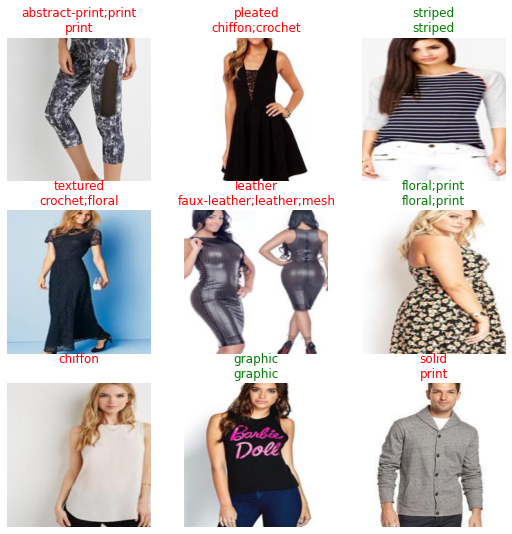

In [32]:
learn.show_results()

<p>Our predictions do not match the labels exactly, but the predicted labels make sense. Overall our model captures the main concepts.</p>

<h3>Evaluation on the Test Dataset</h3>
<p>Now let's load the test data and check how the model performs on it.</p>

In [33]:
test_df = pd.read_csv(TEST_PATH)
test_df.head()

,image_name,labels
0,img\Sheer_Pleated-Front_Blouse\img_00000005.jpg,"feather,pleated"
1,img\Sheer_Pleated-Front_Blouse\img_00000007.jpg,"pleated,sheer"
2,img\Sheer_Pleated-Front_Blouse\img_00000013.jpg,sheer
3,img\Sheer_Pleated-Front_Blouse\img_00000019.jpg,pleated
4,img\Sheer_Pleated-Front_Blouse\img_00000020.jpg,sheer


In [34]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(224)) # Not Sure)

test_dls = dblock.dataloaders(test_df, num_workers=0)

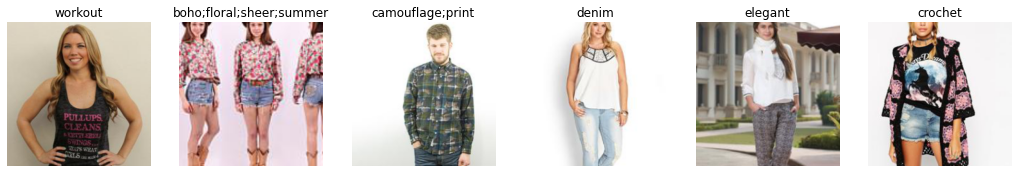

In [35]:
test_dls.show_batch(nrows=1, ncols=6)

In [36]:
learn.data = test_dls
learn.validate()

(#3) [0.22433756291866302,0.44253026656767896,0.9837779402732849]

<p>The model still shows a good FBeta on the test dataset.</p>

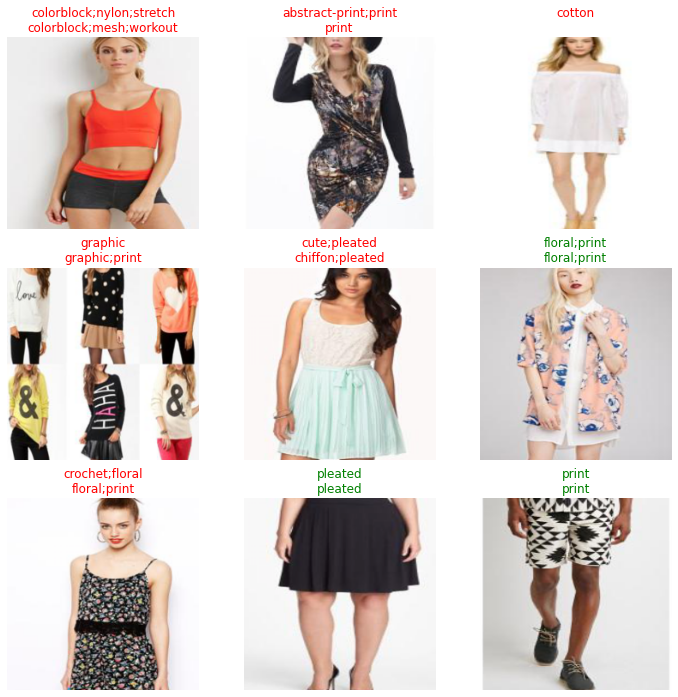

In [37]:
learn.show_results(figsize=(12,12))

<h3>Evaluation on the User Data</h3>
<p>Finally we will check how the model works with the user-specified images. I took 98 pictures of my own clothes with the phone camera. Let's load the images and check whether the model can classify them correctly</p>

In [38]:
def predict_attribute(model, path, display_img=True):
    predicted = model.predict(path)
    if display_img:
        size = 244,244
        img=Image.open(path)
        img.thumbnail(size,Image.ANTIALIAS)
        display(img)
    return predicted[0]

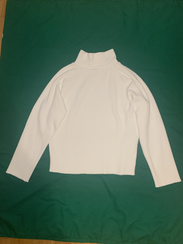

(#1) ['cotton']

In [39]:
image_path = PATH + 'img-phone-jpg/IMG_3032.jpg'
predict_attribute(learn, image_path)

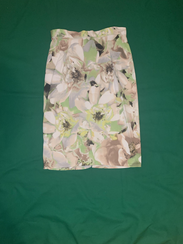

(#2) ['floral','print']

In [40]:
image_path = PATH + 'img-phone-jpg/IMG_3012.jpg'
predict_attribute(learn, image_path)

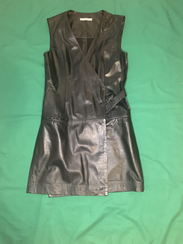

(#1) ['leather']

In [41]:
image_path = PATH + 'img-phone-jpg/IMG_3095.jpg'
predict_attribute(learn, image_path)

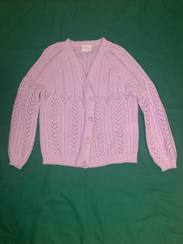

(#1) ['crochet']

In [42]:
image_path = PATH + 'img-phone-jpg/IMG_3106.jpg'
predict_attribute(learn, image_path)

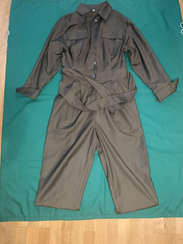

(#3) ['cargo','cotton','utility']

In [43]:
image_path = PATH + 'img-phone-jpg/IMG_3081.jpg'
predict_attribute(learn, image_path)

<p>The assigned labels look very good. Despite the noisy training data, the model was able to learn the fashion concepts and generalize well on the unseen user images. It worth noticing that I did not label my own dataset as it appeared to be a significant effort. Therefore I will use the trained model to obtain labels for my own dataset.</p>